In [1]:
import sys
import os
sys.path.append('/Users/mbassalaev/Desktop/audio_project/Spotter_recognition/')

import pandas as pd
import pickle
import numpy as np

from keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras import backend as K
import librosa
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch, PitchShift, 
    Shift, ClippingDistortion, SpecFrequencyMask, Normalize,
    TimeMask, FrequencyMask)
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

from service.data_augmentation import make_batch, load_background, normalize_df
from models.att_rnn import ATT_RNN_model
from tensorflow.python.ops import gen_audio_ops as audio_ops
from sklearn.metrics import classification_report
import tensorflow as tf

In [2]:
df = pd.read_csv(os.path.abspath('../full_df'))

In [3]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=6464, train_size = 58240, random_state=42)

In [4]:
model = ATT_RNN_model((49, 20, 1), 11)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 45, 20, 10)   60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 45, 20, 10)   40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 41, 20, 1)    51          batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
opt = optimizers.Adam(0.001)
model.compile(optimizer = opt, loss=CategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])

In [7]:
filename = os.path.abspath('../../spotter_data_service/lb')
outfile = open(filename,'rb')
lb = pickle.load(outfile)
outfile.close()

In [8]:
background_folder = '/Users/mbassalaev/Desktop/spotter_data/_background_noise_/'

In [9]:
train_metrics = []
test_metrics = []

noise_to_data = load_background(background_folder)
sr = 16000

p_aug = {
    'gaussian': 1,
    'stretch': 0.3,
    'pitch_shift': 0.3,
    'shift': 0.3,
    'clipping': 0.3,
    'time_mask': 0.5,
    'freq_mask': 0.5
}

X_test, Y_test = normalize_df(df_test, lb, sr, "tensorflow")

start_step = 1
training_steps_list = [20000, 20000, 20000, 20000]
learning_rates_list = [0.001,0.0005,0.0001,0.00002]
training_steps_max = np.sum(training_steps_list)
lr_init = learning_rates_list[0]
exp_rate = -np.log(learning_rates_list[-1] / lr_init) / training_steps_max

In [10]:
for step in range(0, 5000):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 6s 28ms/step - loss: 1.6747 - accuracy: 0.6303
Current step is 50
Train metrics = [1.5455236434936523, 0.640625], Test metrics = [1.6746894121170044, 0.6302598714828491]
101/101 [==============================] - 3s 28ms/step - loss: 1.5870 - accuracy: 0.6303
Current step is 100
Train metrics = [1.930133581161499, 0.46875], Test metrics = [1.5870428085327148, 0.6302598714828491]
101/101 [==============================] - 3s 28ms/step - loss: 1.5101 - accuracy: 0.6303
Current step is 150
Train metrics = [1.458796501159668, 0.640625], Test metrics = [1.510076642036438, 0.6302598714828491]
101/101 [==============================] - 3s 28ms/step - loss: 1.4879 - accuracy: 0.6303
Current step is 200
Train metrics = [1.744982123374939, 0.546875], Test metrics = [1.487935185432434, 0.6302598714828491]
101/101 [==============================] - 3s 28ms/step - loss: 1.4637 - accuracy: 0.6303
Current step is 250
Train metrics = [1.6650686264038086, 0.57

In [11]:
for step in range(0, 2500):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 27ms/step - loss: 0.1603 - accuracy: 0.9494
Current step is 50
Train metrics = [0.386799693107605, 0.859375], Test metrics = [0.1602872759103775, 0.9494121074676514]
101/101 [==============================] - 3s 26ms/step - loss: 0.1503 - accuracy: 0.9545
Current step is 100
Train metrics = [0.38717615604400635, 0.90625], Test metrics = [0.15030361711978912, 0.9545173048973083]
101/101 [==============================] - 3s 26ms/step - loss: 0.1723 - accuracy: 0.9508
Current step is 150
Train metrics = [0.4807223975658417, 0.859375], Test metrics = [0.17226648330688477, 0.9508044719696045]
101/101 [==============================] - 3s 28ms/step - loss: 0.1745 - accuracy: 0.9454
Current step is 200
Train metrics = [0.3592790961265564, 0.90625], Test metrics = [0.1745486557483673, 0.9453898668289185]
101/101 [==============================] - 3s 26ms/step - loss: 0.1746 - accuracy: 0.9463
Current step is 250
Train metrics = [0.3889882266521454

In [12]:
K.set_value(model.optimizer.learning_rate, 0.0005)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 28ms/step - loss: 0.1364 - accuracy: 0.9595
Current step is 50
Train metrics = [0.3537939190864563, 0.84375], Test metrics = [0.13644257187843323, 0.9594678282737732]
101/101 [==============================] - 3s 28ms/step - loss: 0.1285 - accuracy: 0.9624
Current step is 100
Train metrics = [0.41262900829315186, 0.890625], Test metrics = [0.12853331863880157, 0.9624071717262268]
101/101 [==============================] - 3s 28ms/step - loss: 0.1212 - accuracy: 0.9652
Current step is 150
Train metrics = [0.28201547265052795, 0.90625], Test metrics = [0.1212320327758789, 0.9651918411254883]
101/101 [==============================] - 3s 28ms/step - loss: 0.1218 - accuracy: 0.9661
Current step is 200
Train metrics = [0.34820306301116943, 0.90625], Test metrics = [0.12181951850652695, 0.9661200642585754]
101/101 [==============================] - 3s 28ms/step - loss: 0.1236 - accuracy: 0.9652
Current step is 250
Train metrics = [0.5703212618827

In [13]:
K.set_value(model.optimizer.learning_rate, 0.00025)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 27ms/step - loss: 0.1124 - accuracy: 0.9650
Current step is 50
Train metrics = [0.2968254089355469, 0.90625], Test metrics = [0.11240288615226746, 0.9650371074676514]
101/101 [==============================] - 3s 27ms/step - loss: 0.1107 - accuracy: 0.9658
Current step is 100
Train metrics = [0.30332037806510925, 0.921875], Test metrics = [0.11074312031269073, 0.9658106565475464]
101/101 [==============================] - 3s 27ms/step - loss: 0.1123 - accuracy: 0.9658
Current step is 150
Train metrics = [0.2019190788269043, 0.921875], Test metrics = [0.11231783777475357, 0.9658106565475464]
101/101 [==============================] - 3s 27ms/step - loss: 0.1150 - accuracy: 0.9632
Current step is 200
Train metrics = [0.26589614152908325, 0.921875], Test metrics = [0.11502274125814438, 0.9631807208061218]
101/101 [==============================] - 3s 27ms/step - loss: 0.1102 - accuracy: 0.9664
Current step is 250
Train metrics = [0.32946085929

In [14]:
K.set_value(model.optimizer.learning_rate, 0.00025)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 28ms/step - loss: 0.1037 - accuracy: 0.9695
Current step is 50
Train metrics = [0.2597203850746155, 0.9375], Test metrics = [0.10365744680166245, 0.9695234894752502]
101/101 [==============================] - 3s 27ms/step - loss: 0.1026 - accuracy: 0.9695
Current step is 100
Train metrics = [0.38591817021369934, 0.890625], Test metrics = [0.10264821350574493, 0.9695234894752502]
101/101 [==============================] - 3s 27ms/step - loss: 0.1116 - accuracy: 0.9670
Current step is 150
Train metrics = [0.3179202079772949, 0.890625], Test metrics = [0.11164972186088562, 0.9670482873916626]
101/101 [==============================] - 3s 28ms/step - loss: 0.1036 - accuracy: 0.9701
Current step is 200
Train metrics = [0.3825759291648865, 0.890625], Test metrics = [0.10361820459365845, 0.9701423048973083]
101/101 [==============================] - 3s 28ms/step - loss: 0.1050 - accuracy: 0.9688
Current step is 250
Train metrics = [0.2429423630237

In [16]:
K.set_value(model.optimizer.learning_rate, 0.0001)

for step in range(0, 2501):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 29ms/step - loss: 0.1019 - accuracy: 0.9700
Current step is 50
Train metrics = [0.38097018003463745, 0.890625], Test metrics = [0.10188541561365128, 0.9699876308441162]
101/101 [==============================] - 3s 28ms/step - loss: 0.1024 - accuracy: 0.9695
Current step is 100
Train metrics = [0.3041383624076843, 0.890625], Test metrics = [0.10239162296056747, 0.9695234894752502]
101/101 [==============================] - 3s 32ms/step - loss: 0.1027 - accuracy: 0.9698
Current step is 150
Train metrics = [0.329410195350647, 0.875], Test metrics = [0.1026802733540535, 0.9698328971862793]
101/101 [==============================] - 3s 34ms/step - loss: 0.1027 - accuracy: 0.9701
Current step is 200
Train metrics = [0.4487011730670929, 0.859375], Test metrics = [0.10271847248077393, 0.9701423048973083]
101/101 [==============================] - 3s 29ms/step - loss: 0.1021 - accuracy: 0.9703
Current step is 250
Train metrics = [0.1730402857065200

In [17]:
K.set_value(model.optimizer.learning_rate, 0.0001)

for step in range(0, 2001):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 29ms/step - loss: 0.1023 - accuracy: 0.9708
Current step is 50
Train metrics = [0.2250436693429947, 0.9375], Test metrics = [0.10225948691368103, 0.9707611203193665]
101/101 [==============================] - 3s 29ms/step - loss: 0.1005 - accuracy: 0.9706
Current step is 100
Train metrics = [0.38015100359916687, 0.890625], Test metrics = [0.10051288455724716, 0.9706064462661743]
101/101 [==============================] - 3s 28ms/step - loss: 0.1015 - accuracy: 0.9700
Current step is 150
Train metrics = [0.3780534863471985, 0.828125], Test metrics = [0.10150887072086334, 0.9699876308441162]
101/101 [==============================] - 3s 29ms/step - loss: 0.0994 - accuracy: 0.9715
Current step is 200
Train metrics = [0.5588365197181702, 0.828125], Test metrics = [0.09936031699180603, 0.9715346693992615]
101/101 [==============================] - 3s 29ms/step - loss: 0.1012 - accuracy: 0.9709
Current step is 250
Train metrics = [0.2801986336708

In [18]:
K.set_value(model.optimizer.learning_rate, 0.00008)

for step in range(0, 2001):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 27ms/step - loss: 0.0993 - accuracy: 0.9714
Current step is 50
Train metrics = [0.31180548667907715, 0.90625], Test metrics = [0.09933307021856308, 0.9713799357414246]
101/101 [==============================] - 3s 27ms/step - loss: 0.0995 - accuracy: 0.9718
Current step is 100
Train metrics = [0.49306225776672363, 0.84375], Test metrics = [0.09950350970029831, 0.9718440771102905]
101/101 [==============================] - 3s 27ms/step - loss: 0.0994 - accuracy: 0.9715
Current step is 150
Train metrics = [0.25064897537231445, 0.921875], Test metrics = [0.09939463436603546, 0.9715346693992615]
101/101 [==============================] - 3s 27ms/step - loss: 0.1011 - accuracy: 0.9715
Current step is 200
Train metrics = [0.33323028683662415, 0.875], Test metrics = [0.10110010206699371, 0.9715346693992615]
101/101 [==============================] - 3s 27ms/step - loss: 0.0990 - accuracy: 0.9722
Current step is 250
Train metrics = [0.2303557991981

In [19]:
K.set_value(model.optimizer.learning_rate, 0.00005)

for step in range(0, 2001):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 27ms/step - loss: 0.0976 - accuracy: 0.9720
Current step is 50
Train metrics = [0.24115294218063354, 0.90625], Test metrics = [0.09763647615909576, 0.9719987511634827]
101/101 [==============================] - 3s 27ms/step - loss: 0.0977 - accuracy: 0.9723
Current step is 100
Train metrics = [0.22476643323898315, 0.90625], Test metrics = [0.09769567847251892, 0.9723081588745117]
101/101 [==============================] - 3s 27ms/step - loss: 0.0972 - accuracy: 0.9717
Current step is 150
Train metrics = [0.4235351085662842, 0.875], Test metrics = [0.09720857441425323, 0.9716893434524536]
101/101 [==============================] - 3s 27ms/step - loss: 0.0966 - accuracy: 0.9717
Current step is 200
Train metrics = [0.33106186985969543, 0.859375], Test metrics = [0.09661811590194702, 0.9716893434524536]
101/101 [==============================] - 3s 27ms/step - loss: 0.0965 - accuracy: 0.9720
Current step is 250
Train metrics = [0.43002980947494

In [21]:
K.set_value(model.optimizer.learning_rate, 0.00005)

for step in range(0, 3001):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 27ms/step - loss: 0.0954 - accuracy: 0.9725
Current step is 50
Train metrics = [0.2667270600795746, 0.859375], Test metrics = [0.0954093188047409, 0.9724628925323486]
101/101 [==============================] - 3s 27ms/step - loss: 0.0969 - accuracy: 0.9726
Current step is 100
Train metrics = [0.4346879720687866, 0.875], Test metrics = [0.09690037369728088, 0.9726175665855408]
101/101 [==============================] - 3s 27ms/step - loss: 0.0957 - accuracy: 0.9729
Current step is 150
Train metrics = [0.15761278569698334, 0.953125], Test metrics = [0.09574466198682785, 0.9729269742965698]
101/101 [==============================] - 3s 27ms/step - loss: 0.0960 - accuracy: 0.9722
Current step is 200
Train metrics = [0.17464371025562286, 0.953125], Test metrics = [0.09603983908891678, 0.9721534848213196]
101/101 [==============================] - 3s 27ms/step - loss: 0.0965 - accuracy: 0.9718
Current step is 250
Train metrics = [0.38602602481842

In [22]:
K.set_value(model.optimizer.learning_rate, 0.000025)

for step in range(0, 2001):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 27ms/step - loss: 0.0958 - accuracy: 0.9729
Current step is 50
Train metrics = [0.29696109890937805, 0.859375], Test metrics = [0.0958162248134613, 0.9729269742965698]
101/101 [==============================] - 3s 28ms/step - loss: 0.0956 - accuracy: 0.9731
Current step is 100
Train metrics = [0.28119733929634094, 0.90625], Test metrics = [0.09563364833593369, 0.9730817079544067]
101/101 [==============================] - 3s 27ms/step - loss: 0.0955 - accuracy: 0.9732
Current step is 150
Train metrics = [0.2668827772140503, 0.90625], Test metrics = [0.09548601508140564, 0.9732363820075989]
101/101 [==============================] - 3s 27ms/step - loss: 0.0955 - accuracy: 0.9734
Current step is 200
Train metrics = [0.3055356740951538, 0.90625], Test metrics = [0.09548339247703552, 0.9733911156654358]
101/101 [==============================] - 3s 27ms/step - loss: 0.0955 - accuracy: 0.9731
Current step is 250
Train metrics = [0.39849060773849

In [23]:
K.set_value(model.optimizer.learning_rate, 0.000025)

for step in range(0, 51):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 29ms/step - loss: 0.0935 - accuracy: 0.9729
Current step is 50
Train metrics = [0.4831288754940033, 0.84375], Test metrics = [0.09349153190851212, 0.9729269742965698]


In [24]:
K.set_value(model.optimizer.learning_rate, 0.000025)

for step in range(0, 51):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 28ms/step - loss: 0.0946 - accuracy: 0.9732
Current step is 50
Train metrics = [0.3972378671169281, 0.875], Test metrics = [0.09462155401706696, 0.9732363820075989]


In [25]:
K.set_value(model.optimizer.learning_rate, 0.000025)

for step in range(0, 51):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 28ms/step - loss: 0.0942 - accuracy: 0.9735
Current step is 50
Train metrics = [0.21056866645812988, 0.96875], Test metrics = [0.09422305971384048, 0.9735457897186279]


In [26]:
K.set_value(model.optimizer.learning_rate, 0.00001)

for step in range(0, 51):
    X, Y = make_batch(df_train, lb, background_folder, noise_to_data, 64, sr, p_aug, "tensorflow")
    if Y.shape != (64, 11):
        print(f'Bad shape = {Y.shape}')
    #learning_rate_value = lr_init * np.exp(-exp_rate * training_step)
    #K.set_value(model.optimizer.learning_rate, learning_rate_value)
    train_step_metric =  model.train_on_batch(X, Y)
    if step > 0 and step % 50 == 0:
        test_step_metric = model.evaluate(X_test, Y_test, batch_size=64)
        train_metrics.append(train_step_metric)
        test_metrics.append(test_step_metric)
        print(f"Current step is {step}")
        print(f"Train metrics = {train_step_metric}, Test metrics = {test_step_metric}")

101/101 [==============================] - 3s 28ms/step - loss: 0.0943 - accuracy: 0.9734
Current step is 50
Train metrics = [0.19892823696136475, 0.953125], Test metrics = [0.09431006759405136, 0.9733911156654358]


In [34]:
temp = np.arange(50, 30601, 50)

test_acc =[x[1] for x in test_metrics]
test_loss = [x[0] for x in test_metrics]

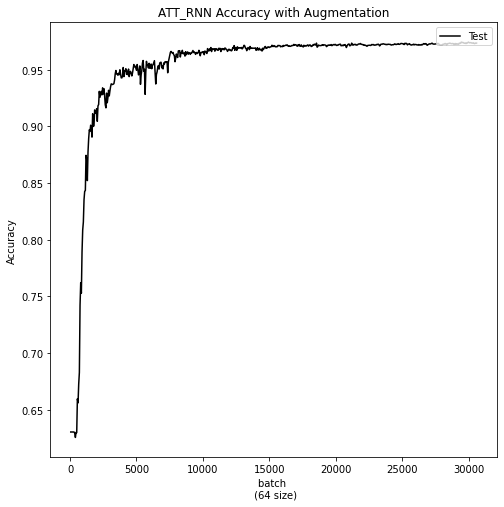

In [35]:
fig = plt.figure(figsize=(8,8))
test_plot = plt.plot(temp, test_acc, color='black', label='Test')
plt.title('ATT_RNN Accuracy with Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('batch \n (64 size)')
plt.legend(loc='upper right')
plt.savefig("ATT_RNN_acc_with_aug", facecolor=fig.get_facecolor(), transparent=True)
plt.show()

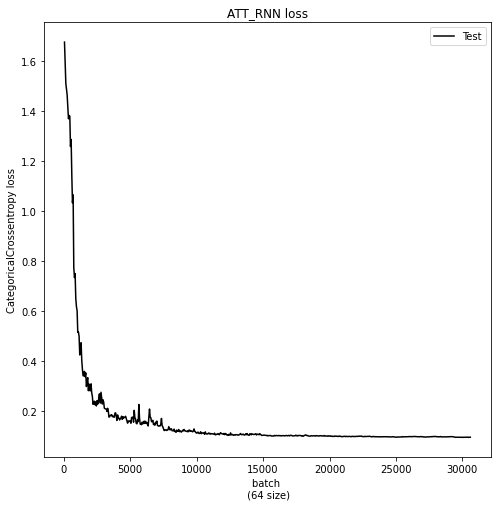

In [36]:
plt.figure(figsize=(8,8))
test_plot = plt.plot(temp, test_loss, color='black', label='Test')
plt.title('ATT_RNN loss')
plt.ylabel('CategoricalCrossentropy loss')
plt.xlabel('batch \n (64 size)')
plt.legend(loc='upper right')
plt.savefig("ATT_RNN_loss_with_aug", facecolor=fig.get_facecolor(), transparent=True)
plt.show()

In [37]:
model.save(os.path.join(os.getcwd(), 'ATT_RNN.h5'), save_format="h5")

In [38]:
def report(model, X, y, classes):
    model_predictions = model.predict(X, batch_size=64).argmax(axis=1)
    true_predictions = y.argmax(axis=1)
    return classification_report(true_predictions, model_predictions, target_names=classes)

In [39]:
print(report(model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.96      0.97      0.96       254
          go       0.99      0.91      0.95       229
        left       0.98      0.94      0.96       236
          no       0.95      0.94      0.95       242
         off       0.99      0.93      0.96       226
          on       0.97      0.95      0.96       229
       right       0.95      0.96      0.95       251
        stop       0.96      0.95      0.95       234
      unkown       0.98      0.99      0.98      4074
          up       0.95      0.95      0.95       250
         yes       0.99      0.97      0.98       239

    accuracy                           0.97      6464
   macro avg       0.97      0.95      0.96      6464
weighted avg       0.97      0.97      0.97      6464



In [40]:
att_rnn_model = tf.keras.models.load_model(os.path.join(os.getcwd(), 'ATT_RNN.h5'))
crnn_model = tf.keras.models.load_model(os.path.join(os.getcwd(), 'CRNN.h5'))

In [41]:
print(report(att_rnn_model, X_test, Y_test, lb.classes_))
print(report(crnn_model, X_test, Y_test, lb.classes_))

              precision    recall  f1-score   support

        down       0.96      0.97      0.96       254
          go       0.99      0.91      0.95       229
        left       0.98      0.94      0.96       236
          no       0.95      0.94      0.95       242
         off       0.99      0.93      0.96       226
          on       0.97      0.95      0.96       229
       right       0.95      0.96      0.95       251
        stop       0.96      0.95      0.95       234
      unkown       0.98      0.99      0.98      4074
          up       0.95      0.95      0.95       250
         yes       0.99      0.97      0.98       239

    accuracy                           0.97      6464
   macro avg       0.97      0.95      0.96      6464
weighted avg       0.97      0.97      0.97      6464

              precision    recall  f1-score   support

        down       0.95      0.96      0.96       254
          go       0.95      0.86      0.90       229
        left       0.97 